In [1]:
import math
import numpy as np
from pyscf import scf, gto, fci
from openfermion import QubitOperator
from openfermion.utils import eigenspectrum
from scipy.sparse import lil_matrix, csr_matrix
from matrix_to_paulis import construct_operators
from openfermionpyscf import run_pyscf

In [2]:
def get_molecular_data(mol, geometry, xyz_format=False):
    '''
    Generate the molecular data of the specified molecule
    '''
    if mol == 'h2':
        mol_data = [
            ['H', [0, 0, 0]],
            ['H', [0, 0, geometry]]
        ]
    elif mol == 'lih':
        mol_data = [
            ['Li', [0, 0, 0]],
            ['H', [0, 0, geometry]]
        ]
    elif mol == 'h2o':
        # Giving symmetrically stretch H2O. ∠HOH = 107.6°
        # Geometry is distance between H-O
        angle = 107.6 / 2
        angle = math.radians(angle)
        x = geometry * math.sin(angle)
        y = geometry * math.cos(angle)
        mol_data = [
            ['O', [0, 0, 0]],
            ['H', [-x, y, 0]],
            ['H', [x, y, 0]]
        ]
    elif mol == 'n2':
        mol_data = [
            ['N', [0, 0, 0]],
            ['N', [0, 0, geometry]]
        ]
    elif mol == 'h4':
        mol_data = [
            ['H', [0, 0, 0]],
            ['H', [0, 0, geometry]],
            ['H', [0, geometry, 0]],
            ['H', [0, geometry, geometry]]
        ]
    elif mol == 'nh3':
        bondAngle = 107
        bondAngle = math.radians(bondAngle)
        cos = math.cos(bondAngle)
        sin = math.sin(bondAngle)

        # The idea is second and third vecctor dot product is cos(angle) * geometry^2.
        thirdyRatio = (cos - cos**2) / sin
        thirdxRatio = (1 - cos**2 - thirdyRatio**2) ** (1/2)
        mol_data = [
            ['H', [0.0, 0.0, geometry]],
            ['H', [0.0, sin * geometry, cos * geometry]],
            ['H', [thirdxRatio * geometry, thirdyRatio * geometry, cos * geometry]],
            ['N', [0.0, 0.0, 0.0]]
            ]

    else:
        raise(ValueError(mol, 'Unknown moleucles given'))

    if xyz_format:
        return convert_mol_data_to_xyz_format(mol_data)
    else:
        return mol_data

In [3]:
class KrylovSubspace(object):
    '''Krylov subspace expansion.'''
    def __init__(self, h, b, tol=1e-10):
        self.h = csr_matrix(h)
        self.b = b
        self._tol = tol
        self._generate_subspace()

    def _generate_subspace(self, maxmul=65):
        '''Calculate subspace.'''
        emax = np.max(self.h.diagonal())
        h = csr_matrix(self.h.copy())
        for i in range(h.shape[0]):
            h[i, i] -= emax
        b = np.copy(self.b)
        b /= self.norm(b)
        ls = [b]
        for i in range(min(h.shape[0], maxmul)):
            bi = h.dot(ls[-1])
            bi /= self.norm(bi)
            ls.append(bi)
        subs = np.array(ls).T
        subs = self.gram_schmidt_columns(subs)
        self._subspace = subs

    @staticmethod
    def gram_schmidt_columns(X):
        Q, R = np.linalg.qr(X)
        return Q
    
    @property
    def n_subspace(self, ):
        ''' '''
        return self._subspace.shape[1]

    def expand_c(self, csub):
        ''' '''
        subs = self._subspace
        c = subs.dot(csub)
        return c

    def get_hsub(self, ):
        ''' '''
        h = self.h
        subs = self._subspace
        matrix_sub = subs.T.conj().dot(h.dot(subs))
        n_size = matrix_sub.shape[0]
        for i in range(n_size - 3):
            for j in range(i + 2, n_size):
                matrix_sub[i, j] = 0
                matrix_sub[j, i] = 0
        matrix_sub = (matrix_sub + matrix_sub.T.conj()) / 2
        return lil_matrix(matrix_sub)

    @staticmethod
    def norm(p):
        return np.sqrt(np.sum(np.abs(p) ** 2))

In [4]:
def get_qubit_hamiltonian(mol, geometry, basis, charge=0, multiplicity=1, qubit_transf='jw'):
    '''
    Generating qubit hamiltonina of the given molecules with specified geometry, basis sets, charge and multiplicity
    Give its qubit form using specified transformation
    '''
    g = get_molecular_data(mol, geometry)
    mol = gto.Mole(atom=g, basis=basis)
    mol.build()
    mf = scf.RHF(mol)
    mf.kernel()
    cisolver = fci.FCI(mol, mf.mo_coeff)
    cisolver.nroots = 10000
    cisolver.kernel()
    eci = cisolver.eci
    nci = len(eci)
    cci = np.array(cisolver.ci, dtype=float).reshape(nci, -1)
    hamiltonian_matrix = cci.dot(np.diag(eci).dot(cci.T))
    hamiltonian_matrix = np.round(hamiltonian_matrix, 10)
    # Subspace.
    b = np.zeros(hamiltonian_matrix.shape[0])
    b[0] = 1
    hamiltonian_matrix = KrylovSubspace(lil_matrix(hamiltonian_matrix), b).get_hsub()
    print(hamiltonian_matrix.shape)
    hamq = construct_operators(hamiltonian_matrix)
    nqubits = int(np.ceil(np.log2(hamiltonian_matrix.shape[0])))
    return (remove_complex(hamq), nqubits, eci[0])

In [5]:
def convert_mol_data_to_xyz_format(mol_data):
    '''
    Convert nuclear geometry list to .xyz format.
    '''

    xyz_str = ''
    for atom in mol_data:
        xyz_str += atom[0] +' ' + ' '.join([f"{coord:.10f}" for coord in atom[1]]) +'\n'

    return xyz_str

In [6]:
def remove_complex(H : QubitOperator, tiny=1e-8):
    '''
    Removing near-zero complex coefficient
    '''
    real_h = QubitOperator.zero()
    for term, val in H.terms.items():
        if np.imag(val) < tiny:
            val = np.real(val)
        real_h += QubitOperator(term=term, coefficient=val)
    return real_h

## Molecules
1. H2
2. H2O
3. N2
3. LiH
4. NH3

### H2

In [7]:
qubit_transf = 'jw' # Jordan-Wigner transformations
h2 = get_qubit_hamiltonian(mol='h2', geometry=1, basis='sto3g', qubit_transf=qubit_transf)
print(h2)

converged SCF energy = -1.06610864931794
(4, 4)
(-0.5400662795 [] +
0.009014930099999985 [Z0] +
-0.1967905835 [Z0 X1] +
-0.26752864995000003 [Z0 Z1] +
-0.26752864995000003 [Z1], 2, -1.1011503302326195)


### H2O

In [38]:
qubit_transf = 'jw' # Jordan-Wigner transformations
h2o = get_qubit_hamiltonian(mol='h2o', geometry=1, basis='sto3g', qubit_transf=qubit_transf)
print(h2o)

converged SCF energy = -74.9629830304642
(66, 66)
(-32.40835650926701 [] +
0.013641016016764266 [X0 X1 X2 X3 X4 X5] +
-0.016212981706922123 [X0 X1 X2 X3 X4 X5 X6] +
-0.013641016016764266 [X0 X1 X2 X3 X4 X5 Z6] +
0.016212981706922123 [X0 X1 X2 X3 X4 Y5 Y6] +
0.016212981706922123 [X0 X1 X2 X3 Y4 X5 Y6] +
-0.013641016016764266 [X0 X1 X2 X3 Y4 Y5] +
0.016212981706922123 [X0 X1 X2 X3 Y4 Y5 X6] +
0.013641016016764266 [X0 X1 X2 X3 Y4 Y5 Z6] +
0.016212981706922123 [X0 X1 X2 Y3 X4 X5 Y6] +
-0.013641016016764266 [X0 X1 X2 Y3 X4 Y5] +
0.016212981706922123 [X0 X1 X2 Y3 X4 Y5 X6] +
0.013641016016764266 [X0 X1 X2 Y3 X4 Y5 Z6] +
-0.013641016016764266 [X0 X1 X2 Y3 Y4 X5] +
0.016212981706922123 [X0 X1 X2 Y3 Y4 X5 X6] +
0.013641016016764266 [X0 X1 X2 Y3 Y4 X5 Z6] +
-0.016212981706922123 [X0 X1 X2 Y3 Y4 Y5 Y6] +
0.016212981706922123 [X0 X1 Y2 X3 X4 X5 Y6] +
-0.013641016016764266 [X0 X1 Y2 X3 X4 Y5] +
0.016212981706922123 [X0 X1 Y2 X3 X4 Y5 X6] +
0.013641016016764266 [X0 X1 Y2 X3 X4 Y5 Z6] +
-0.0136410160

### N2

In [21]:
#qubit_transf = 'jw' # Jordan-Wigner transformations
#n2 = get_qubit_hamiltonian(mol='n2', geometry=1, basis='sto3g', qubit_transf=qubit_transf)
#print(n2)

### LiH

In [22]:
qubit_transf = 'jw' # Jordan-Wigner transformations
lih = get_qubit_hamiltonian(mol='lih', geometry=1, basis='sto3g', qubit_transf=qubit_transf)
print(lih)

converged SCF energy = -7.76736213574856
(66, 66)
(-2.1295783606416507 [] +
0.0026766319727109912 [X0 X1 X2 X3 X4 X5] +
-0.00028930702957246377 [X0 X1 X2 X3 X4 X5 X6] +
-0.0026766319727109912 [X0 X1 X2 X3 X4 X5 Z6] +
0.00028930702957246377 [X0 X1 X2 X3 X4 Y5 Y6] +
0.00028930702957246377 [X0 X1 X2 X3 Y4 X5 Y6] +
-0.0026766319727109912 [X0 X1 X2 X3 Y4 Y5] +
0.00028930702957246377 [X0 X1 X2 X3 Y4 Y5 X6] +
0.0026766319727109912 [X0 X1 X2 X3 Y4 Y5 Z6] +
0.00028930702957246377 [X0 X1 X2 Y3 X4 X5 Y6] +
-0.0026766319727109912 [X0 X1 X2 Y3 X4 Y5] +
0.00028930702957246377 [X0 X1 X2 Y3 X4 Y5 X6] +
0.0026766319727109912 [X0 X1 X2 Y3 X4 Y5 Z6] +
-0.0026766319727109912 [X0 X1 X2 Y3 Y4 X5] +
0.00028930702957246377 [X0 X1 X2 Y3 Y4 X5 X6] +
0.0026766319727109912 [X0 X1 X2 Y3 Y4 X5 Z6] +
-0.00028930702957246377 [X0 X1 X2 Y3 Y4 Y5 Y6] +
0.00028930702957246377 [X0 X1 Y2 X3 X4 X5 Y6] +
-0.0026766319727109912 [X0 X1 Y2 X3 X4 Y5] +
0.00028930702957246377 [X0 X1 Y2 X3 X4 Y5 X6] +
0.0026766319727109912 [X0 X1 

### Nh3

In [9]:
#qubit_transf = 'jw' # Jordan-Wigner transformations
#nh3 = get_qubit_hamiltonian(mol='nh3', geometry=1, basis='sto3g', qubit_transf=qubit_transf)
#print(nh3)

In [8]:
from qiskit.aqua.operators.legacy import  WeightedPauliOperator
from qiskit.quantum_info import Pauli


### Generalised

In [9]:
def create_operator(ham, n):
    hams = str(ham)
    op = []
    h = []
    g = ''
    for i in range (len(hams)):
        if hams[i] =='+':
            h.append(g)
            g = ''

        elif hams[i] =='\n':
            continue
        else:
            g = g+hams[i]
    h.append(g)
    for k in range (1,len(h)):
        y = []
        g = ''
        for i in range (len(h[k])):
            if h[k][i] == '[' or h[k][i] == ']':
                y.append(g)
                g = ''
            else:
                g = g+h[k][i]
        b = []
        g = ''
        for i in range(len(y[1])):
            if y[1][i] == ' ':
                b.append(g)
                g = ''

            else:
                g = g+y[1][i]
        b.append(g)
        
        c = []

        for i in range (len(b)):
            g = ''
            for j in range(1,len(b[i])):
                g = g+ b[i][j]
            #print(g)
            c.append([int(g),b[i][0]])
            
            
        d = ''
        for i in range(n):
            l = 0
            for j in range(len(c)):
                if c[j][0] == i :
                    d = d+c[j][1]
                    l =1
            if l ==0:
                d =d+'I'
        

        
        #print(d)
        
        op.append((float(y[0]),Pauli(label = d)))
    p = ''
    for i in range (n):
            p=p+'I'
    g = ''
    f = []
    for i in range (len(h[0])):
        if h[0][i] == '[':
            f.append(g)
            g = ''
        else:
            g = g+h[0][i]
    
    op.append((float(f[0]),Pauli(label = p)))

    operator = WeightedPauliOperator(op, basis=None, z2_symmetries=None, atol=1e-12, name=None)
    return operator

### VQE

In [10]:
dist = 1.5
op, n, e0 = get_qubit_hamiltonian(mol='h2', geometry=dist, basis='sto3g', qubit_transf=qubit_transf)
#h2o = get_qubit_hamiltonian(mol='h2o', geometry=dist, basis='sto3g', qubit_transf=qubit_transf)
#n2 = get_qubit_hamiltonian(mol='n2', geometry=dist, basis='sto3g', qubit_transf=qubit_transf)
#lih = get_qubit_hamiltonian(mol='lih', geometry=dist, basis='sto3g', qubit_transf=qubit_transf)
#nh3 = get_qubit_hamiltonian(mol='nh3', geometry=dist, basis='sto3g', qubit_transf=qubit_transf)
print(eigenspectrum(op))
opt = create_operator(op, n)

converged SCF energy = -0.910873554594386
(4, 4)
[-0.99814935 -0.89058478 -0.43151291 -0.3071925 ]


In [11]:
exact_solution = e0
print(exact_solution)

-0.9981493534714097


In [12]:
from qiskit.aqua.algorithms import VQE, NumPyEigensolver
from qiskit.aqua.components.optimizers import COBYLA
from qiskit.circuit.library import EfficientSU2
from qiskit.aqua import QuantumInstance
from qiskit.aqua.components.variational_forms import RY, RYRZ, SwapRZ
from qiskit import IBMQ, BasicAer, Aer
import matplotlib.pyplot as plt
import numpy as np

#Define Backend
backend = BasicAer.get_backend("statevector_simulator")

#Define Optimizer
optimizer = COBYLA(maxiter=500, tol=0.001)


# Distance 
Distance = []
Energy = []

#Distance.append(0.74)


#Define Number of qubits
#n = 4

#Define Ansatz
# ansatz = EfficientSU2(num_qubits=n, entanglement='linear')
ansatz = RY(n)
# quantum_instance = QuantumInstance(backend, shots=1024)
quantum_instance = QuantumInstance(backend)
#display(ansatz.draw('mpl'))

#Operators

operators = [opt]

# Run VQE 

for ops in operators:
    #experiment = VQE(ops,ansatz,optimizer)
    algo = VQE(ops, ansatz, optimizer)
    #energy = np.real(experiment.run(backend)['eigenvalue']) # energy shift?
    algo_result = algo.run(quantum_instance)
    result_ry = algo_result['optimal_value']
    print('VQE Result : ',result_ry)
    Energy.append(result_ry)


/home/codie/miniconda3/envs/bhumi/lib/python3.7/site-packages/ipykernel_launcher.py:29: DeprecationWarning: The qiskit.aqua.components.variational_forms.RY object is deprecated as of 0.7.0 and will be removed no sooner than 3 months after the release. You should use qiskit.circuit.library.RealAmplitudes (uses CX entangling) or qiskit.circuit.library.TwoLocal instead.


VQE Result :  -0.9981492285839728


## Copamrison

### H2

In [71]:
Exact_Energy = []
VQE_Energy = []
Distance = []
for i in range(1,20):
        dist = 0.2*i
        Distance.append(dist)
        op, n, e0 = get_qubit_hamiltonian(mol='h2', geometry=dist, basis='sto3g', qubit_transf=qubit_transf)
        opt = create_operator(op, n)
        Exact_Energy.append(e0)
        ansatz = RY(n)
        algo = VQE(opt, ansatz, optimizer)
        algo_result = algo.run(quantum_instance)
        result_ry = algo_result['optimal_value']
        print('VQE Result : ',result_ry)
        VQE_Energy.append(result_ry)
        

converged SCF energy = 0.164175012061696
(4, 4)


/home/codie/miniconda3/envs/bhumi/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: The qiskit.aqua.components.variational_forms.RY object is deprecated as of 0.7.0 and will be removed no sooner than 3 months after the release. You should use qiskit.circuit.library.RealAmplitudes (uses CX entangling) or qiskit.circuit.library.TwoLocal instead.
  # Remove the CWD from sys.path while we load stuff.


VQE Result :  0.1574825167778556
converged SCF energy = -0.904361394163539
(4, 4)


/home/codie/miniconda3/envs/bhumi/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: The qiskit.aqua.components.variational_forms.RY object is deprecated as of 0.7.0 and will be removed no sooner than 3 months after the release. You should use qiskit.circuit.library.RealAmplitudes (uses CX entangling) or qiskit.circuit.library.TwoLocal instead.
  # Remove the CWD from sys.path while we load stuff.


VQE Result :  -0.9141485063739557
converged SCF energy = -1.1011282422677
(4, 4)


/home/codie/miniconda3/envs/bhumi/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: The qiskit.aqua.components.variational_forms.RY object is deprecated as of 0.7.0 and will be removed no sooner than 3 months after the release. You should use qiskit.circuit.library.RealAmplitudes (uses CX entangling) or qiskit.circuit.library.TwoLocal instead.
  # Remove the CWD from sys.path while we load stuff.


VQE Result :  -1.1162856595087634
converged SCF energy = -1.1108503974766
(4, 4)


/home/codie/miniconda3/envs/bhumi/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: The qiskit.aqua.components.variational_forms.RY object is deprecated as of 0.7.0 and will be removed no sooner than 3 months after the release. You should use qiskit.circuit.library.RealAmplitudes (uses CX entangling) or qiskit.circuit.library.TwoLocal instead.
  # Remove the CWD from sys.path while we load stuff.


VQE Result :  -1.1341471912739487
converged SCF energy = -1.06610864931794
(4, 4)


/home/codie/miniconda3/envs/bhumi/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: The qiskit.aqua.components.variational_forms.RY object is deprecated as of 0.7.0 and will be removed no sooner than 3 months after the release. You should use qiskit.circuit.library.RealAmplitudes (uses CX entangling) or qiskit.circuit.library.TwoLocal instead.
  # Remove the CWD from sys.path while we load stuff.


VQE Result :  -1.1011498941739735
converged SCF energy = -1.00510670656849
(4, 4)


/home/codie/miniconda3/envs/bhumi/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: The qiskit.aqua.components.variational_forms.RY object is deprecated as of 0.7.0 and will be removed no sooner than 3 months after the release. You should use qiskit.circuit.library.RealAmplitudes (uses CX entangling) or qiskit.circuit.library.TwoLocal instead.
  # Remove the CWD from sys.path while we load stuff.


VQE Result :  -1.0567405885041696
converged SCF energy = -0.941480654707798
(4, 4)


/home/codie/miniconda3/envs/bhumi/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: The qiskit.aqua.components.variational_forms.RY object is deprecated as of 0.7.0 and will be removed no sooner than 3 months after the release. You should use qiskit.circuit.library.RealAmplitudes (uses CX entangling) or qiskit.circuit.library.TwoLocal instead.
  # Remove the CWD from sys.path while we load stuff.


VQE Result :  -1.0154678932732544
converged SCF energy = -0.881732449946056
(4, 4)


/home/codie/miniconda3/envs/bhumi/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: The qiskit.aqua.components.variational_forms.RY object is deprecated as of 0.7.0 and will be removed no sooner than 3 months after the release. You should use qiskit.circuit.library.RealAmplitudes (uses CX entangling) or qiskit.circuit.library.TwoLocal instead.
  # Remove the CWD from sys.path while we load stuff.


VQE Result :  -0.9834725551097973
converged SCF energy = -0.828848147926978
(4, 4)


/home/codie/miniconda3/envs/bhumi/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: The qiskit.aqua.components.variational_forms.RY object is deprecated as of 0.7.0 and will be removed no sooner than 3 months after the release. You should use qiskit.circuit.library.RealAmplitudes (uses CX entangling) or qiskit.circuit.library.TwoLocal instead.
  # Remove the CWD from sys.path while we load stuff.


VQE Result :  -0.9618164247797436
converged SCF energy = -0.783792654277353
(4, 4)


/home/codie/miniconda3/envs/bhumi/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: The qiskit.aqua.components.variational_forms.RY object is deprecated as of 0.7.0 and will be removed no sooner than 3 months after the release. You should use qiskit.circuit.library.RealAmplitudes (uses CX entangling) or qiskit.circuit.library.TwoLocal instead.
  # Remove the CWD from sys.path while we load stuff.


VQE Result :  -0.9486378068481499
converged SCF energy = -0.746401349991159
(4, 4)


/home/codie/miniconda3/envs/bhumi/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: The qiskit.aqua.components.variational_forms.RY object is deprecated as of 0.7.0 and will be removed no sooner than 3 months after the release. You should use qiskit.circuit.library.RealAmplitudes (uses CX entangling) or qiskit.circuit.library.TwoLocal instead.
  # Remove the CWD from sys.path while we load stuff.


VQE Result :  -0.9405569510816459
converged SCF energy = -0.715910060453806
(4, 4)


/home/codie/miniconda3/envs/bhumi/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: The qiskit.aqua.components.variational_forms.RY object is deprecated as of 0.7.0 and will be removed no sooner than 3 months after the release. You should use qiskit.circuit.library.RealAmplitudes (uses CX entangling) or qiskit.circuit.library.TwoLocal instead.
  # Remove the CWD from sys.path while we load stuff.


VQE Result :  -0.9363157088973282
converged SCF energy = -0.691327561197377
(4, 4)


/home/codie/miniconda3/envs/bhumi/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: The qiskit.aqua.components.variational_forms.RY object is deprecated as of 0.7.0 and will be removed no sooner than 3 months after the release. You should use qiskit.circuit.library.RealAmplitudes (uses CX entangling) or qiskit.circuit.library.TwoLocal instead.
  # Remove the CWD from sys.path while we load stuff.


VQE Result :  -0.9340110080323609
converged SCF energy = -0.671668859751728
(4, 4)


/home/codie/miniconda3/envs/bhumi/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: The qiskit.aqua.components.variational_forms.RY object is deprecated as of 0.7.0 and will be removed no sooner than 3 months after the release. You should use qiskit.circuit.library.RealAmplitudes (uses CX entangling) or qiskit.circuit.library.TwoLocal instead.
  # Remove the CWD from sys.path while we load stuff.


VQE Result :  -0.9328122810498509
converged SCF energy = -0.656048251145591
(4, 4)


/home/codie/miniconda3/envs/bhumi/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: The qiskit.aqua.components.variational_forms.RY object is deprecated as of 0.7.0 and will be removed no sooner than 3 months after the release. You should use qiskit.circuit.library.RealAmplitudes (uses CX entangling) or qiskit.circuit.library.TwoLocal instead.
  # Remove the CWD from sys.path while we load stuff.


VQE Result :  -0.9329431861189067
converged SCF energy = -0.643689931022628
(4, 4)


/home/codie/miniconda3/envs/bhumi/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: The qiskit.aqua.components.variational_forms.RY object is deprecated as of 0.7.0 and will be removed no sooner than 3 months after the release. You should use qiskit.circuit.library.RealAmplitudes (uses CX entangling) or qiskit.circuit.library.TwoLocal instead.
  # Remove the CWD from sys.path while we load stuff.


VQE Result :  -0.9332222756216251
converged SCF energy = -0.633919132947047
(4, 4)


/home/codie/miniconda3/envs/bhumi/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: The qiskit.aqua.components.variational_forms.RY object is deprecated as of 0.7.0 and will be removed no sooner than 3 months after the release. You should use qiskit.circuit.library.RealAmplitudes (uses CX entangling) or qiskit.circuit.library.TwoLocal instead.
  # Remove the CWD from sys.path while we load stuff.


VQE Result :  -0.9331638121930923
converged SCF energy = -0.626159758066403
(4, 4)


/home/codie/miniconda3/envs/bhumi/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: The qiskit.aqua.components.variational_forms.RY object is deprecated as of 0.7.0 and will be removed no sooner than 3 months after the release. You should use qiskit.circuit.library.RealAmplitudes (uses CX entangling) or qiskit.circuit.library.TwoLocal instead.
  # Remove the CWD from sys.path while we load stuff.


VQE Result :  -0.9331818172537956
converged SCF energy = -0.619936028447048
(4, 4)


/home/codie/miniconda3/envs/bhumi/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: The qiskit.aqua.components.variational_forms.RY object is deprecated as of 0.7.0 and will be removed no sooner than 3 months after the release. You should use qiskit.circuit.library.RealAmplitudes (uses CX entangling) or qiskit.circuit.library.TwoLocal instead.
  # Remove the CWD from sys.path while we load stuff.


VQE Result :  -0.9331629777624719


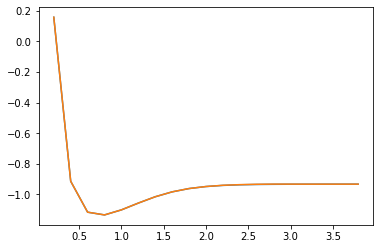

In [74]:
import matplotlib.pyplot as plt
plt.plot(Distance,Exact_Energy)
plt.plot(Distance,VQE_Energy)

### LIH

In [13]:
Exact_Energy_lih = []
VQE_Energy_lih = []
Distance = []
optimizer = COBYLA(maxiter=500, tol=0.00001)
for i in range(1,20):
        dist = 0.1*i
        Distance.append(dist)
        op, n, e0 = get_qubit_hamiltonian(mol='lih', geometry=dist, basis='sto3g', qubit_transf=qubit_transf)
        opt = create_operator(op, n)
        Exact_Energy_lih.append(e0)
        ansatz = RY(n)
        algo = VQE(opt, ansatz, optimizer)
        algo_result = algo.run(quantum_instance)
        result_ry = algo_result['optimal_value']
        print('VQE Result : ',result_ry)
        VQE_Energy_lih.append(result_ry)
        

converged SCF energy = 2.80287805218653
(66, 66)


/home/codie/miniconda3/envs/bhumi/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: The qiskit.aqua.components.variational_forms.RY object is deprecated as of 0.7.0 and will be removed no sooner than 3 months after the release. You should use qiskit.circuit.library.RealAmplitudes (uses CX entangling) or qiskit.circuit.library.TwoLocal instead.
  # This is added back by InteractiveShellApp.init_path()


VQE Result :  0.004501619775876164
converged SCF energy = -3.9998444872802
(66, 66)


/home/codie/miniconda3/envs/bhumi/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: The qiskit.aqua.components.variational_forms.RY object is deprecated as of 0.7.0 and will be removed no sooner than 3 months after the release. You should use qiskit.circuit.library.RealAmplitudes (uses CX entangling) or qiskit.circuit.library.TwoLocal instead.
  # This is added back by InteractiveShellApp.init_path()


VQE Result :  -4.010998191600685
converged SCF energy = -5.84243683078952
(66, 66)


/home/codie/miniconda3/envs/bhumi/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: The qiskit.aqua.components.variational_forms.RY object is deprecated as of 0.7.0 and will be removed no sooner than 3 months after the release. You should use qiskit.circuit.library.RealAmplitudes (uses CX entangling) or qiskit.circuit.library.TwoLocal instead.
  # This is added back by InteractiveShellApp.init_path()


VQE Result :  -5.8470244358166426
converged SCF energy = -6.61025894411097
(66, 66)


/home/codie/miniconda3/envs/bhumi/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: The qiskit.aqua.components.variational_forms.RY object is deprecated as of 0.7.0 and will be removed no sooner than 3 months after the release. You should use qiskit.circuit.library.RealAmplitudes (uses CX entangling) or qiskit.circuit.library.TwoLocal instead.
  # This is added back by InteractiveShellApp.init_path()


VQE Result :  -6.624541742454047
converged SCF energy = -7.02841009454193
(66, 66)


/home/codie/miniconda3/envs/bhumi/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: The qiskit.aqua.components.variational_forms.RY object is deprecated as of 0.7.0 and will be removed no sooner than 3 months after the release. You should use qiskit.circuit.library.RealAmplitudes (uses CX entangling) or qiskit.circuit.library.TwoLocal instead.
  # This is added back by InteractiveShellApp.init_path()


VQE Result :  -6.894472923519265
converged SCF energy = -7.29954105134224
(66, 66)


/home/codie/miniconda3/envs/bhumi/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: The qiskit.aqua.components.variational_forms.RY object is deprecated as of 0.7.0 and will be removed no sooner than 3 months after the release. You should use qiskit.circuit.library.RealAmplitudes (uses CX entangling) or qiskit.circuit.library.TwoLocal instead.
  # This is added back by InteractiveShellApp.init_path()


VQE Result :  -6.80724868770872
converged SCF energy = -7.48594487054728
(66, 66)


/home/codie/miniconda3/envs/bhumi/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: The qiskit.aqua.components.variational_forms.RY object is deprecated as of 0.7.0 and will be removed no sooner than 3 months after the release. You should use qiskit.circuit.library.RealAmplitudes (uses CX entangling) or qiskit.circuit.library.TwoLocal instead.
  # This is added back by InteractiveShellApp.init_path()


VQE Result :  -7.238074799960217
converged SCF energy = -7.6157701612321
(66, 66)


/home/codie/miniconda3/envs/bhumi/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: The qiskit.aqua.components.variational_forms.RY object is deprecated as of 0.7.0 and will be removed no sooner than 3 months after the release. You should use qiskit.circuit.library.RealAmplitudes (uses CX entangling) or qiskit.circuit.library.TwoLocal instead.
  # This is added back by InteractiveShellApp.init_path()


VQE Result :  -7.6297909930608965
converged SCF energy = -7.70575334013612
(66, 66)


/home/codie/miniconda3/envs/bhumi/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: The qiskit.aqua.components.variational_forms.RY object is deprecated as of 0.7.0 and will be removed no sooner than 3 months after the release. You should use qiskit.circuit.library.RealAmplitudes (uses CX entangling) or qiskit.circuit.library.TwoLocal instead.
  # This is added back by InteractiveShellApp.init_path()


VQE Result :  -7.676304289398454
converged SCF energy = -7.76736213574856
(66, 66)


/home/codie/miniconda3/envs/bhumi/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: The qiskit.aqua.components.variational_forms.RY object is deprecated as of 0.7.0 and will be removed no sooner than 3 months after the release. You should use qiskit.circuit.library.RealAmplitudes (uses CX entangling) or qiskit.circuit.library.TwoLocal instead.
  # This is added back by InteractiveShellApp.init_path()


VQE Result :  -6.2516477558732415
converged SCF energy = -7.80874317649342
(66, 66)


/home/codie/miniconda3/envs/bhumi/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: The qiskit.aqua.components.variational_forms.RY object is deprecated as of 0.7.0 and will be removed no sooner than 3 months after the release. You should use qiskit.circuit.library.RealAmplitudes (uses CX entangling) or qiskit.circuit.library.TwoLocal instead.
  # This is added back by InteractiveShellApp.init_path()


VQE Result :  -7.816190757531646
converged SCF energy = -7.83561582555692
(66, 66)


/home/codie/miniconda3/envs/bhumi/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: The qiskit.aqua.components.variational_forms.RY object is deprecated as of 0.7.0 and will be removed no sooner than 3 months after the release. You should use qiskit.circuit.library.RealAmplitudes (uses CX entangling) or qiskit.circuit.library.TwoLocal instead.
  # This is added back by InteractiveShellApp.init_path()


VQE Result :  -7.577732522112333
converged SCF energy = -7.85195385795624
(66, 66)


/home/codie/miniconda3/envs/bhumi/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: The qiskit.aqua.components.variational_forms.RY object is deprecated as of 0.7.0 and will be removed no sooner than 3 months after the release. You should use qiskit.circuit.library.RealAmplitudes (uses CX entangling) or qiskit.circuit.library.TwoLocal instead.
  # This is added back by InteractiveShellApp.init_path()


VQE Result :  -7.453441943218234
converged SCF energy = -7.86053866102069
(66, 66)


/home/codie/miniconda3/envs/bhumi/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: The qiskit.aqua.components.variational_forms.RY object is deprecated as of 0.7.0 and will be removed no sooner than 3 months after the release. You should use qiskit.circuit.library.RealAmplitudes (uses CX entangling) or qiskit.circuit.library.TwoLocal instead.
  # This is added back by InteractiveShellApp.init_path()


VQE Result :  -7.867915465403389
converged SCF energy = -7.86335762153511
(66, 66)


/home/codie/miniconda3/envs/bhumi/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: The qiskit.aqua.components.variational_forms.RY object is deprecated as of 0.7.0 and will be removed no sooner than 3 months after the release. You should use qiskit.circuit.library.RealAmplitudes (uses CX entangling) or qiskit.circuit.library.TwoLocal instead.
  # This is added back by InteractiveShellApp.init_path()


VQE Result :  -7.878625854168127
converged SCF energy = -7.86186476980865
(66, 66)


/home/codie/miniconda3/envs/bhumi/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: The qiskit.aqua.components.variational_forms.RY object is deprecated as of 0.7.0 and will be removed no sooner than 3 months after the release. You should use qiskit.circuit.library.RealAmplitudes (uses CX entangling) or qiskit.circuit.library.TwoLocal instead.
  # This is added back by InteractiveShellApp.init_path()


VQE Result :  -7.879193628424115
converged SCF energy = -7.85714496020383
(66, 66)


/home/codie/miniconda3/envs/bhumi/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: The qiskit.aqua.components.variational_forms.RY object is deprecated as of 0.7.0 and will be removed no sooner than 3 months after the release. You should use qiskit.circuit.library.RealAmplitudes (uses CX entangling) or qiskit.circuit.library.TwoLocal instead.
  # This is added back by InteractiveShellApp.init_path()


VQE Result :  -7.625736156213767
converged SCF energy = -7.8500186971668
(66, 66)


/home/codie/miniconda3/envs/bhumi/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: The qiskit.aqua.components.variational_forms.RY object is deprecated as of 0.7.0 and will be removed no sooner than 3 months after the release. You should use qiskit.circuit.library.RealAmplitudes (uses CX entangling) or qiskit.circuit.library.TwoLocal instead.
  # This is added back by InteractiveShellApp.init_path()


VQE Result :  -7.785658020176736
converged SCF energy = -7.8411120407714
(66, 66)


/home/codie/miniconda3/envs/bhumi/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: The qiskit.aqua.components.variational_forms.RY object is deprecated as of 0.7.0 and will be removed no sooner than 3 months after the release. You should use qiskit.circuit.library.RealAmplitudes (uses CX entangling) or qiskit.circuit.library.TwoLocal instead.
  # This is added back by InteractiveShellApp.init_path()


VQE Result :  -7.862684762329895


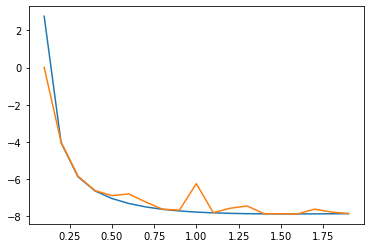

In [14]:
plt.plot(Distance,Exact_Energy_lih)
plt.plot(Distance,VQE_Energy_lih)

### H2O

In [22]:
Exact_Energy_h2o = []
VQE_Energy_h2o = []
Distance = []
optimizer = COBYLA(maxiter=1000, tol=0.0001)
for i in range(1,20):
        dist = 0.2*i
        Distance.append(dist)
        op, n, e0 = get_qubit_hamiltonian(mol='h2o', geometry=dist, basis='sto3g', qubit_transf=qubit_transf)
        opt = create_operator(op, n)
        Exact_Energy_h2o.append(e0)
        ansatz = RY(n)
        algo = VQE(opt, ansatz, optimizer)
        algo_result = algo.run(quantum_instance)
        result_ry = algo_result['optimal_value']
        print('VQE Result : ',result_ry)
        VQE_Energy_h2o.append(result_ry)
        print(i)

converged SCF energy = -56.177972434867
(66, 66)


/home/codie/miniconda3/envs/bhumi/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: The qiskit.aqua.components.variational_forms.RY object is deprecated as of 0.7.0 and will be removed no sooner than 3 months after the release. You should use qiskit.circuit.library.RealAmplitudes (uses CX entangling) or qiskit.circuit.library.TwoLocal instead.
  # This is added back by InteractiveShellApp.init_path()


VQE Result :  -50.08399692036971
1
converged SCF energy = -71.0701191144883
(66, 66)


/home/codie/miniconda3/envs/bhumi/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: The qiskit.aqua.components.variational_forms.RY object is deprecated as of 0.7.0 and will be removed no sooner than 3 months after the release. You should use qiskit.circuit.library.RealAmplitudes (uses CX entangling) or qiskit.circuit.library.TwoLocal instead.
  # This is added back by InteractiveShellApp.init_path()


VQE Result :  -70.96310211284157
2
converged SCF energy = -74.1312042014678
(66, 66)


/home/codie/miniconda3/envs/bhumi/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: The qiskit.aqua.components.variational_forms.RY object is deprecated as of 0.7.0 and will be removed no sooner than 3 months after the release. You should use qiskit.circuit.library.RealAmplitudes (uses CX entangling) or qiskit.circuit.library.TwoLocal instead.
  # This is added back by InteractiveShellApp.init_path()


VQE Result :  -73.66560944186494
3
converged SCF energy = -74.8506620064994
(66, 66)


/home/codie/miniconda3/envs/bhumi/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: The qiskit.aqua.components.variational_forms.RY object is deprecated as of 0.7.0 and will be removed no sooner than 3 months after the release. You should use qiskit.circuit.library.RealAmplitudes (uses CX entangling) or qiskit.circuit.library.TwoLocal instead.
  # This is added back by InteractiveShellApp.init_path()


VQE Result :  -75.29545787022151
4
converged SCF energy = -74.9629830304641
(66, 66)


/home/codie/miniconda3/envs/bhumi/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: The qiskit.aqua.components.variational_forms.RY object is deprecated as of 0.7.0 and will be removed no sooner than 3 months after the release. You should use qiskit.circuit.library.RealAmplitudes (uses CX entangling) or qiskit.circuit.library.TwoLocal instead.
  # This is added back by InteractiveShellApp.init_path()


VQE Result :  -72.85507930688117
5
converged SCF energy = -74.8928760566119
(66, 66)


/home/codie/miniconda3/envs/bhumi/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: The qiskit.aqua.components.variational_forms.RY object is deprecated as of 0.7.0 and will be removed no sooner than 3 months after the release. You should use qiskit.circuit.library.RealAmplitudes (uses CX entangling) or qiskit.circuit.library.TwoLocal instead.
  # This is added back by InteractiveShellApp.init_path()


VQE Result :  -72.02467505321893
6
converged SCF energy = -74.768957451989
(66, 66)


/home/codie/miniconda3/envs/bhumi/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: The qiskit.aqua.components.variational_forms.RY object is deprecated as of 0.7.0 and will be removed no sooner than 3 months after the release. You should use qiskit.circuit.library.RealAmplitudes (uses CX entangling) or qiskit.circuit.library.TwoLocal instead.
  # This is added back by InteractiveShellApp.init_path()


VQE Result :  -69.9262058292498
7
converged SCF energy = -74.635639705199
(66, 66)


/home/codie/miniconda3/envs/bhumi/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: The qiskit.aqua.components.variational_forms.RY object is deprecated as of 0.7.0 and will be removed no sooner than 3 months after the release. You should use qiskit.circuit.library.RealAmplitudes (uses CX entangling) or qiskit.circuit.library.TwoLocal instead.
  # This is added back by InteractiveShellApp.init_path()


VQE Result :  -71.49597577114685
8
converged SCF energy = -74.5097655114063
(66, 66)


/home/codie/miniconda3/envs/bhumi/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: The qiskit.aqua.components.variational_forms.RY object is deprecated as of 0.7.0 and will be removed no sooner than 3 months after the release. You should use qiskit.circuit.library.RealAmplitudes (uses CX entangling) or qiskit.circuit.library.TwoLocal instead.
  # This is added back by InteractiveShellApp.init_path()


VQE Result :  -74.0149023150811
9
converged SCF energy = -74.4005469565458
(66, 66)


/home/codie/miniconda3/envs/bhumi/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: The qiskit.aqua.components.variational_forms.RY object is deprecated as of 0.7.0 and will be removed no sooner than 3 months after the release. You should use qiskit.circuit.library.RealAmplitudes (uses CX entangling) or qiskit.circuit.library.TwoLocal instead.
  # This is added back by InteractiveShellApp.init_path()


VQE Result :  -74.64277564121369
10
converged SCF energy = -74.3089437369891
(66, 66)


/home/codie/miniconda3/envs/bhumi/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: The qiskit.aqua.components.variational_forms.RY object is deprecated as of 0.7.0 and will be removed no sooner than 3 months after the release. You should use qiskit.circuit.library.RealAmplitudes (uses CX entangling) or qiskit.circuit.library.TwoLocal instead.
  # This is added back by InteractiveShellApp.init_path()


VQE Result :  -69.59503178394115
11
converged SCF energy = -74.2368613352531
(66, 66)


/home/codie/miniconda3/envs/bhumi/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: The qiskit.aqua.components.variational_forms.RY object is deprecated as of 0.7.0 and will be removed no sooner than 3 months after the release. You should use qiskit.circuit.library.RealAmplitudes (uses CX entangling) or qiskit.circuit.library.TwoLocal instead.
  # This is added back by InteractiveShellApp.init_path()


VQE Result :  -69.52000940823774
12
SCF not converged.
SCF energy = -72.9688161985757
(66, 66)


/home/codie/miniconda3/envs/bhumi/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: The qiskit.aqua.components.variational_forms.RY object is deprecated as of 0.7.0 and will be removed no sooner than 3 months after the release. You should use qiskit.circuit.library.RealAmplitudes (uses CX entangling) or qiskit.circuit.library.TwoLocal instead.
  # This is added back by InteractiveShellApp.init_path()


VQE Result :  -74.43460957349198
13
SCF not converged.
SCF energy = -73.0714956667793
(66, 66)


/home/codie/miniconda3/envs/bhumi/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: The qiskit.aqua.components.variational_forms.RY object is deprecated as of 0.7.0 and will be removed no sooner than 3 months after the release. You should use qiskit.circuit.library.RealAmplitudes (uses CX entangling) or qiskit.circuit.library.TwoLocal instead.
  # This is added back by InteractiveShellApp.init_path()


VQE Result :  -71.33001306135556
14
converged SCF energy = -74.263731434031
(66, 66)


/home/codie/miniconda3/envs/bhumi/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: The qiskit.aqua.components.variational_forms.RY object is deprecated as of 0.7.0 and will be removed no sooner than 3 months after the release. You should use qiskit.circuit.library.RealAmplitudes (uses CX entangling) or qiskit.circuit.library.TwoLocal instead.
  # This is added back by InteractiveShellApp.init_path()


VQE Result :  -71.70020998962592
15
SCF not converged.
SCF energy = -72.8340702774302
(66, 66)


/home/codie/miniconda3/envs/bhumi/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: The qiskit.aqua.components.variational_forms.RY object is deprecated as of 0.7.0 and will be removed no sooner than 3 months after the release. You should use qiskit.circuit.library.RealAmplitudes (uses CX entangling) or qiskit.circuit.library.TwoLocal instead.
  # This is added back by InteractiveShellApp.init_path()


VQE Result :  -74.06157488992676
16
SCF not converged.
SCF energy = -72.8380527311562
(66, 66)


/home/codie/miniconda3/envs/bhumi/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: The qiskit.aqua.components.variational_forms.RY object is deprecated as of 0.7.0 and will be removed no sooner than 3 months after the release. You should use qiskit.circuit.library.RealAmplitudes (uses CX entangling) or qiskit.circuit.library.TwoLocal instead.
  # This is added back by InteractiveShellApp.init_path()


VQE Result :  -70.29695096417832
17
SCF not converged.
SCF energy = -72.7795883762304
(66, 66)


/home/codie/miniconda3/envs/bhumi/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: The qiskit.aqua.components.variational_forms.RY object is deprecated as of 0.7.0 and will be removed no sooner than 3 months after the release. You should use qiskit.circuit.library.RealAmplitudes (uses CX entangling) or qiskit.circuit.library.TwoLocal instead.
  # This is added back by InteractiveShellApp.init_path()


VQE Result :  -73.0808062623714
18
converged SCF energy = -74.2508165711419
(66, 66)


/home/codie/miniconda3/envs/bhumi/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: The qiskit.aqua.components.variational_forms.RY object is deprecated as of 0.7.0 and will be removed no sooner than 3 months after the release. You should use qiskit.circuit.library.RealAmplitudes (uses CX entangling) or qiskit.circuit.library.TwoLocal instead.
  # This is added back by InteractiveShellApp.init_path()


VQE Result :  -72.3027345461183
19


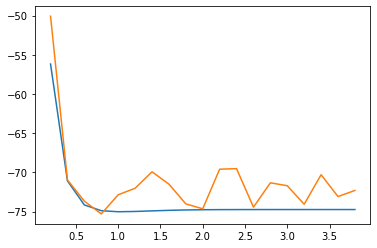

In [24]:
plt.plot(Distance,Exact_Energy_h2o)
plt.plot(Distance,VQE_Energy_h2o)

### N2


In [20]:
Exact_Energy_n2 = []
VQE_Energy_n2 = []
Distance = []
optimizer = COBYLA(maxiter=500, tol=0.001)
for i in range(1,20):
        dist = 0.2*i
        Distance.append(dist)
        op, n, e0 = get_qubit_hamiltonian(mol='n2', geometry=dist, basis='sto3g', qubit_transf=qubit_transf)
        opt = create_operator(op, n)
        Exact_Energy_n2.append(e0)
        ansatz = RY(n)
        algo = VQE(opt, ansatz, optimizer)
        algo_result = algo.run(quantum_instance)
        result_ry = algo_result['optimal_value']
        print('VQE Result : ',result_ry)
        VQE_Energy_n2.append(result_ry)

converged SCF energy = -52.6419222048253
